# Target variability tracking with TF variability

In [1]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from pybedtools import BedTool
import pickle as pkl
%matplotlib inline
import itertools

In [2]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.5-py3.8.egg')
sys.path.append('/home/ssm-user/Github/misc-seq/miscseq')
import encode
import memento

In [191]:
data_path = '/data_volume/ifn_hbec/'
fig_path = '/home/ssm-user/Github/scrna-parameter-estimation/figures/fig4/main/'

In [4]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [5]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)

### Read 1d HT result comparing to control

In [6]:
cts = [['ciliated']]
tps = ['3', '6', '9', '24', '48']
stims = ['alpha', 'beta', 'gamma', 'lambda']

In [7]:
def read_result(ct):
    
    ht_dict = {}
    moments_dict = {}
    
    for stim in stims:
        ht_dict[stim] = {}
        moments_dict[stim] = {}
        for tp in tps: 
            adata_subset = sc.read('/data_volume/ifn_hbec/binary_test_deep/{}_{}_{}_20200313.h5ad'.format('-'.join(ct), stim, tp))
            ht_dict[stim][tp] = memento.get_1d_ht_result(adata_subset)
            ht_dict[stim][tp]['de_fdr'] = memento.util._fdrcorrect(ht_dict[stim][tp]['de_pval'])
            ht_dict[stim][tp]['dv_fdr'] = memento.util._fdrcorrect(ht_dict[stim][tp]['dv_pval'])
            moments_dict[stim][tp] = memento.get_1d_moments(adata_subset, groupby='time_step')
    return ht_dict,moments_dict

In [8]:
all_result = {}
for ct in cts:
    
    key = '-'.join(ct)
    all_result[key] = {}
    
    all_result[key]['ht'], all_result[key]['moments'] = read_result(ct)

### Get genes that are likely ISGF3 binding

In [9]:
enc = encode.Encode('/home/ssm-user/Github/misc-seq/miscseq/GRCh38Genes.bed')

In [10]:
stat1_bed = enc.get_encode_peaks_union([
    'https://www.encodeproject.org/files/ENCFF747ICD/@@download/ENCFF747ICD.bed.gz',
    'https://www.encodeproject.org/files/ENCFF646MXG/@@download/ENCFF646MXG.bed.gz'
])
stat2_bed = enc.get_encode_peaks_union([
    'https://www.encodeproject.org/files/ENCFF204VQS/@@download/ENCFF204VQS.bed.gz',
    'https://www.encodeproject.org/files/ENCFF545JVD/@@download/ENCFF545JVD.bed.gz'
])

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/ssm-user/anaconda3/envs/single_cell/lib/python

In [11]:
intersect_bed = stat1_bed.intersect(stat2_bed).sort()

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)


In [12]:
isgf3_genes = enc.get_peak_genes_bed(intersect_bed, 0).query('distance == 0 & ~gene.str.contains("MT").values').gene.tolist()

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pybedtools/bedtool.py:3678: UserWarning: Default names for filetype bed are:
['chrom', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts']
but file 

### Get genes that are likely GAF binding

In [13]:
stat1_bed = enc.get_encode_peaks_union([
    'https://www.encodeproject.org/files/ENCFF431NLF/@@download/ENCFF431NLF.bed.gz',
    'https://www.encodeproject.org/files/ENCFF646MXG/@@download/ENCFF646MXG.bed.gz'
])

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)


In [14]:
potential_gaf_genes = enc\
    .get_peak_genes_encode('https://www.encodeproject.org/files/ENCFF431NLF/@@download/ENCFF431NLF.bed.gz', 0)\
    .query('distance == 0 & ~gene.str.contains("MT").values').gene.tolist()

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pybedtools/bedtool.py:3678: UserWarning: Default names for filetype bed are:
['chrom', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts']
but file 

In [15]:
baseline_stat1_genes = enc\
    .get_peak_genes_encode('https://www.encodeproject.org/files/ENCFF323QQU/@@download/ENCFF323QQU.bed.gz', 0)\
    .query('distance == 0 & ~gene.str.contains("MT").values').gene.tolist()

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/subprocess.py:853: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pybedtools/bedtool.py:3678: UserWarning: Default names for filetype bed are:
['chrom', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts']
but file 

In [16]:
gaf_genes =potential_gaf_genes #list(set(potential_gaf_genes) - set(baseline_stat1_genes))

### Functions for constructing DF/variability vectors

In [84]:
def get_moment_df(stim):
    
    df = all_result['ciliated']['moments'][stim]['3'][1].rename(columns={'time_step_0':'time_0', 'time_step_1':'time_3'})[['gene','time_0','time_3']]
    
    for tp in ['6', '9', '24', '48']:
        
        df = df.merge(all_result['ciliated']['moments'][stim][tp][1].rename(columns={'time_step_1':'time_'+tp})[['gene', 'time_'+tp]], on='gene')
    return df

def get_var_vector(df, gene):
    
    return df.query('gene == "{}"'.format(gene)).values.reshape(-1)[1:]

### Compute correlations between STAT1 and downstream genes

In [96]:
def get_vcorrs(stim, tf, tss_genes):
    
    df = get_moment_df(stim)
    upreg_genes = all_result['ciliated']['ht'][stim]['6'].query('de_coef > 0 & de_fdr < 0.05').gene.tolist()
    target_genes = list(set(upreg_genes) & set(tss_genes) & set(df.gene))
    tf_vector = get_var_vector(df, tf)

    tf_vcorr = []
    for g in target_genes:
        target_vector = get_var_vector(df, g)
        tf_vcorr.append(stats.pearsonr(tf_vector, target_vector)[0])

    random_vcorr = []
    nontarget_genes = list(set(upreg_genes) & set(df.gene))
    for trial in range(1000):
        g1 = np.random.choice(nontarget_genes)
        g2 = np.random.choice(nontarget_genes)

        if g1 == g2:
            continue

        g1_vector = get_var_vector(df, g1)
        g2_vector = get_var_vector(df, g2)
        random_vcorr.append(stats.pearsonr(g1_vector, g2_vector)[0])

    print(stats.ks_2samp(tf_vcorr, random_vcorr))
    return tf_vcorr, random_vcorr

In [98]:
beta_stat1_vcorr, beta_random_vcorr = get_vcorrs('beta', 'STAT1', isgf3_genes)
beta_stat2_vcorr, beta_random_vcorr2 = get_vcorrs('beta', 'STAT2', isgf3_genes)
gamma_stat1_vcorr, gamma_random_vcorr = get_vcorrs('gamma', 'STAT1', gaf_genes)

KstestResult(statistic=0.35785785785785784, pvalue=1.1953216194626748e-11)
KstestResult(statistic=0.4171671671671672, pvalue=1.6653345369377348e-15)
KstestResult(statistic=0.22944444444444445, pvalue=0.0031556144960810384)


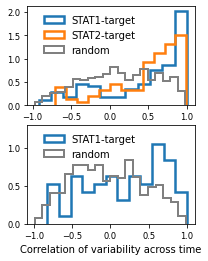

In [192]:
plt.figure(figsize=(3, 4));
plt.subplots_adjust(wspace=0.3, hspace=0.2)
plt.subplot(2, 1, 1);
plt.hist(beta_stat1_vcorr, histtype='step', bins=12, density=True, lw=2.5, label='STAT1-target');
plt.hist(beta_stat2_vcorr, histtype='step', bins=12, density=True, lw=2.5, label='STAT2-target');
plt.hist(beta_random_vcorr, histtype='step', bins=20, density=True, lw=2, color='gray', label='random');
plt.legend(frameon=False, loc='upper right', bbox_to_anchor=(0.7, 1))
plt.subplot(2, 1, 2);
plt.hist(gamma_stat1_vcorr, histtype='step', bins=12, density=True, lw=2.5);
plt.hist(gamma_random_vcorr, histtype='step', bins=20, density=True, lw=2, color='gray');
plt.ylim(0, 1.3)
plt.legend(['STAT1-target', 'random'], frameon=False, loc='upper right', bbox_to_anchor=(0.7, 1))
plt.xlabel('Correlation of variability across time')
plt.savefig(fig_path + 'var_tracking.pdf', bbox_inches='tight')
